In [51]:
import tensorflow as tf
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets.mnist import load_data
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model

# Deep Convolutional Neural Network

In [52]:
# Load Dataset
batch_size = 128 # Jumlah data yang mau di proses dalam sekali pemrosesan
nb_classes = 10 # 0 - 9

img_cols, img_rows = 28, 28 # 28x28 pixels

# Load dataset
(X, y), (X_test, y_test) = load_data()
# mnist -> Ambil dataset dari tensorflow

X = np.concatenate([X, X_test], axis=0)
y = np.concatenate([y, y_test], axis=0)



In [53]:
# Splitting Dataset

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

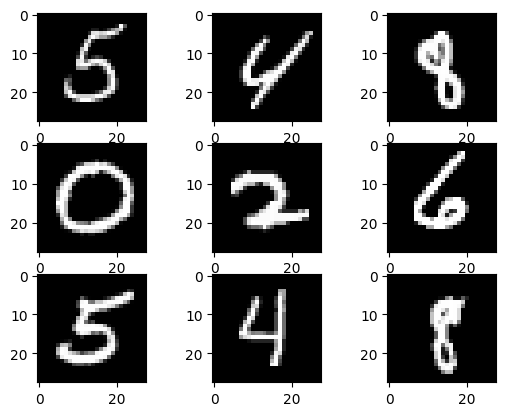

In [54]:
# Preprocessing / Augmented

# Reshape and Rescale dari 0 -1 
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1) # 1 -> Channel [Gray Scale]
X_train = X_train.astype('float32') / 255.0

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32') / 255.0

X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32') / 255.0

# One Hot Encoding
Y_train = to_categorical(y_train, nb_classes)
y_val = to_categorical(y_val, nb_classes)
y_test = to_categorical(y_test, nb_classes)
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.imshow(X_train[i], cmap='gray')
plt.show()

In [73]:
# Make residual block

# A residual block is a stack of layers set in such a way that the output of a layer is taken and added to another layer deeper in the block
# Skip Connections

# Down sample -> apakah kita perlu memperkecil dimensi nya atau tidak
def residual_block(X, filters, down_sample=None):
    X_shortcut = X
    if down_sample:
        stride = 2  
        # Semakin kecil stride maka semakin kecil output nya
        X_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='valid')(X_shortcut)
        X_shortcut = BatchNormalization()(X_shortcut)
    else:
        stride = 1

    X = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(X)
    X = BatchNormalization()(X)

    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    return X


def resnet_18(input_shape, nb_classes):
  X_input = Input(input_shape)

  X = Conv2D(64, kernel_size=(7,7), strides=(2, 2), padding='same')(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2,2))(X)

  X = residual_block(X, 64)
  X = residual_block(X, 64)

  X = residual_block(X, 128,True)
  X = residual_block(X, 128)

  X = residual_block(X, 256,True)
  X = residual_block(X, 256)

  X = residual_block(X, 512,True)
  X = residual_block(X, 512)

  X = GlobalAveragePooling2D()(X)
  X = Dense(nb_classes,activation='softmax')(X)

  model = Model(inputs=X_input, outputs=X)
  return model

model = resnet_18(input_shape=(img_rows, img_cols, 1), nb_classes=nb_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print Architecture:
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_44 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_307 (Conv2D)         (None, 14, 14, 64)           3200      ['input_44[0][0]']            
                                                                                                  
 batch_normalization_307 (B  (None, 14, 14, 64)           256       ['conv2d_307[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_246 (Activation  (None, 14, 14, 64)           0         ['batch_normalization_30

In [75]:
# Training
history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/10
438/438 [==============================] - 462s 1s/step - loss: 0.1144 - accuracy: 0.9666 - val_loss: 0.2309 - val_accuracy: 0.9287
Epoch 2/10
438/438 [==============================] - 450s 1s/step - loss: 0.0553 - accuracy: 0.9832 - val_loss: 0.1145 - val_accuracy: 0.9690
Epoch 3/10
438/438 [==============================] - 457s 1s/step - loss: 0.0370 - accuracy: 0.9885 - val_loss: 0.0643 - val_accuracy: 0.9814
Epoch 4/10
438/438 [==============================] - 457s 1s/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.1278 - val_accuracy: 0.9653
Epoch 5/10
438/438 [==============================] - 466s 1s/step - loss: 0.0286 - accuracy: 0.9910 - val_loss: 0.0902 - val_accuracy: 0.9717
Epoch 6/10
438/438 [==============================] - 453s 1s/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.0992 - val_accuracy: 0.9756
Epoch 7/10
438/438 [==============================] - 451s 1s/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0712 - val_accuracy: 0.9799

In [76]:
# Score the model
score = model.evaluate(X_test, y_test)
print(f'Test Score: {score[0]}')
print(f'Test Accuracy: {score[1]}')

219/219 [==============================] - 4s 19ms/step - loss: 0.0910 - accuracy: 0.9791
Test Score: 0.0909552276134491
Test Accuracy: 0.9791428446769714


219/219 [==============================] - 6s 25ms/step
[[1.5886596e-11 7.5829816e-13 3.3403339e-13 ... 2.7742684e-12
  6.4042560e-10 1.2711909e-07]
 [2.4152791e-11 2.2031385e-14 2.3700871e-14 ... 1.5071846e-12
  2.2858204e-07 3.9431902e-11]
 [6.7672638e-12 1.0452854e-11 8.5369011e-13 ... 4.3116341e-10
  7.6714396e-06 9.9999166e-01]
 ...
 [1.0401294e-06 7.8311223e-06 5.0740252e-04 ... 9.9830246e-01
  7.2057697e-04 7.8914090e-05]
 [4.7657056e-18 3.9410969e-13 1.0000000e+00 ... 1.5707638e-13
  1.2162999e-09 7.7129744e-15]
 [3.1576387e-18 6.5526234e-19 4.5948211e-21 ... 7.5238264e-21
  1.0000000e+00 1.7768978e-19]]


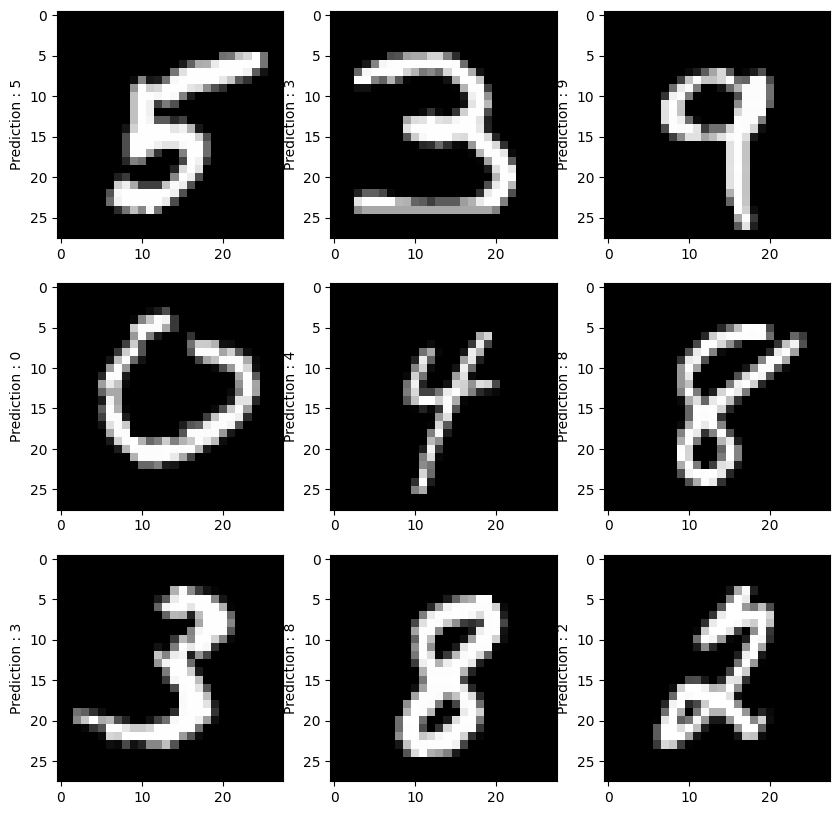

In [85]:
# Build Predictions

predictions = model.predict(X_test)
print(predictions)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10, 10))

for i in range(9):
  plt.subplot(3, 3,i + 1)
  plt.imshow(X_test[i], cmap='gray')
  plt.ylabel(f'Prediction : {predicted_labels[i]}')

# plt.savefig('Predictions Plot.png')
plt.show()

['loss', 'accuracy', 'val_loss', 'val_accuracy']


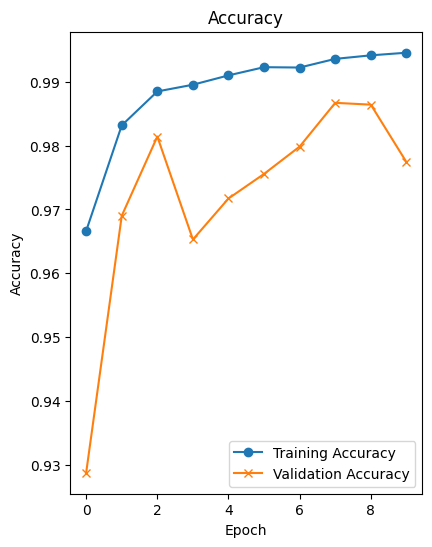

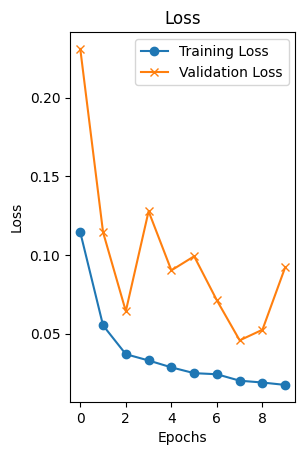

In [94]:
print(list(history.history.keys()))

# Sub plot to see models quality

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'x-', label="Validation Accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'o-', label ='Training Loss')
plt.plot(history.history['val_loss'],'x-', label ='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Semakin turun angkanya semakin bagus